In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
from glob import glob
import skimage.io as io
import shutil

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\unet\sessile-main-Kvasir-SEG


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG"
print(os.listdir(data_dir))

['text_data', 'masks', 'images']


# Split data

In [5]:
def create_text_file(data_dict, data_type, img_txt_path, mask_txt_path = None):
    
    with open(img_txt_path, 'w') as f:
        with open(mask_txt_path, 'w') as i:
            for key, value in data_dict.items():
                f.write(value[0])
                i.write(value[1])

                f.write("\n")
                i.write("\n")
                
    print("\n\n{0} files created.\nImages: {1}\nMasks: {2}".format(data_type.capitalize(), img_txt_path, mask_txt_path))
    return

def split_data(data_direct, seed, split_ratio = [.80, .20]):
    img_dir = os.path.join(data_direct, "images")
    mask_dir = os.path.join(data_direct, "masks")
    
    data_dict = {}
    for image in os.listdir(img_dir):
        img_path = os.path.join(img_dir, image)
        mask_path = os.path.join(mask_dir, image)
        data_dict[image] = [img_path, mask_path]

    # Random Seed
    random.seed(random_seed)
    data_list = list(data_dict.items())
    random.shuffle(data_list)
    
        
    # Data split
    train_size = int(len(data_list)*split_ratio[0])
    test_size = len(data_list) - train_size

    train_dict = dict(data_list[:train_size])
    test_dict = dict(data_list[train_size:])
    
    return train_dict, test_dict

data_direct = "text_data"
os.makedirs(data_direct, exist_ok=True)
random_seed = 42
split_ratio = [.80, .20]

train_dict, test_dict = split_data(data_dir, random_seed, split_ratio)

train_img_txt = "text_data/train_images.txt"
train_mask_txt = "text_data/train_masks.txt"

test_img_txt = "text_data/test_images.txt"
test_mask_txt = "text_data/test_masks.txt"

create_text_file(train_dict, "train", train_img_txt, train_mask_txt)
create_text_file(test_dict, "test", test_img_txt, test_mask_txt)

#new_data = shutil.move(data_direct, bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG")



Train files created.
Images: text_data/train_images.txt
Masks: text_data/train_masks.txt


Test files created.
Images: text_data/test_images.txt
Masks: text_data/test_masks.txt


In [6]:
new_data = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG/text_data"
print(os.listdir(new_data))

['test_masks.txt', 'test_images.txt', 'train_masks.txt', 'train_images.txt']


In [7]:
def count_lines_in_files(file_paths):
    result = {}
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            num_lines = len(lines)
            result[file_path] = num_lines
    return result

# List of paths to files to count
file_paths = [new_data + '/train_images.txt', 
              new_data + '/test_images.txt', 
              new_data + '/train_masks.txt',
              new_data + '/test_masks.txt']

# Calculate len
line_counts = count_lines_in_files(file_paths)

# Print
for file_path, line_count in line_counts.items():
    print(f"Lines in {file_path}: {line_count}")

Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/train_images.txt: 156
Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/test_images.txt: 40
Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/train_masks.txt: 156
Lines in /home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/test_masks.txt: 40


# Custom Dataset

In [8]:
class PolypDataset(Dataset):
    def __init__(self, data_file, label_file, input_size):
        with open(data_file) as f:
            self.image_paths = f.readlines()
        f.close()
        
        with open(label_file) as f:
            self.label_paths = f.readlines()
        f.close()

        self.image_paths = [x.strip() for x in self.image_paths]
        self.label_paths = [x.strip() for x in self.label_paths]
        
        self.input_size = input_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = io.imread(self.label_paths[idx])
        label = self.target_transform()(label)

        img = io.imread(self.image_paths[idx])
        img = self.transform()(img)
        return (img, label)
    def transform(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4, 0.4, 0.4), (0.4, 0.4, 0.4))
            ])
    def target_transform(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.input_size),
            transforms.ToTensor()
            ])    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


156


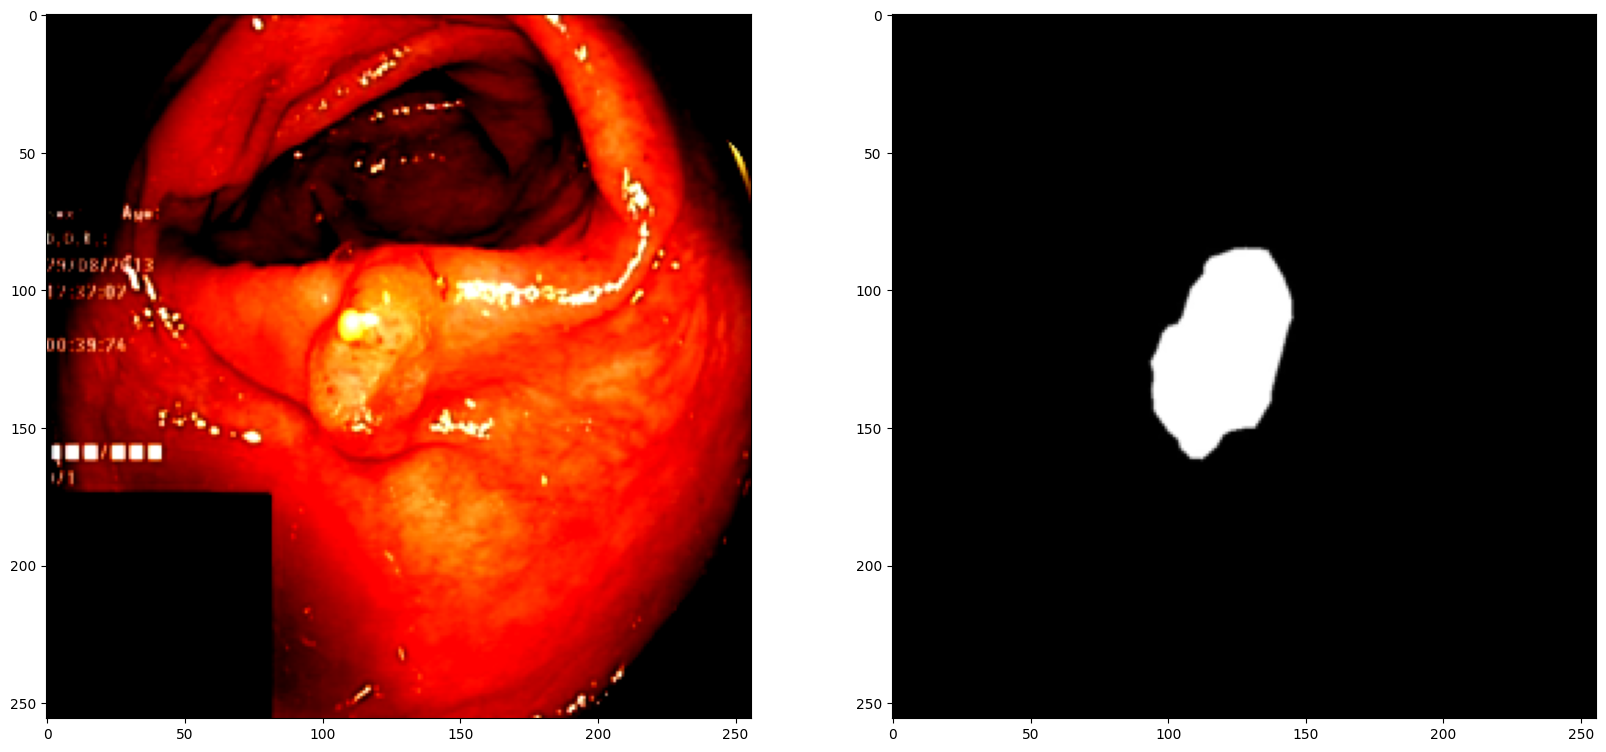

In [9]:
# Input size for model
input_size = (256, 256)

# Create train sets
train_images_file = new_data + '/train_images.txt'
train_labels_file = new_data + '/train_masks.txt'

train_ds = PolypDataset(train_images_file, train_labels_file, input_size)

print(len(train_ds))

img, msk = train_ds[15]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

# DataLoader

In [10]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

8


In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [12]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [13]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [14]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [17]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.29it/s]


Epoch: 0 - TrainLoss: 0.5040493458509445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Epoch: 1 - TrainLoss: 0.45072193071246147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.83it/s]


Epoch: 2 - TrainLoss: 0.41931743919849396


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Epoch: 3 - TrainLoss: 0.39373408257961273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Epoch: 4 - TrainLoss: 0.37353651598095894


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Epoch: 5 - TrainLoss: 0.3571251779794693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


Epoch: 6 - TrainLoss: 0.342442624270916


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch: 7 - TrainLoss: 0.3249497562646866


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


Epoch: 8 - TrainLoss: 0.31264637410640717


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


Epoch: 9 - TrainLoss: 0.2992115430533886


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


Epoch: 10 - TrainLoss: 0.28928207606077194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch: 11 - TrainLoss: 0.27801402658224106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Epoch: 12 - TrainLoss: 0.27190977334976196


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Epoch: 13 - TrainLoss: 0.2613759394735098


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Epoch: 14 - TrainLoss: 0.2526899427175522


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


Epoch: 15 - TrainLoss: 0.2443475741893053


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


Epoch: 16 - TrainLoss: 0.23839069157838821


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Epoch: 17 - TrainLoss: 0.23506584018468857


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


Epoch: 18 - TrainLoss: 0.2282521314918995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.90it/s]


Epoch: 19 - TrainLoss: 0.2194649912416935


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.58it/s]


Epoch: 20 - TrainLoss: 0.21444986388087273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Epoch: 21 - TrainLoss: 0.21043032221496105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.52it/s]


Epoch: 22 - TrainLoss: 0.1970713771879673


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


Epoch: 23 - TrainLoss: 0.196071470156312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Epoch: 24 - TrainLoss: 0.1923809666186571


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.62it/s]


Epoch: 25 - TrainLoss: 0.18784734420478344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


Epoch: 26 - TrainLoss: 0.17630522325634956


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch: 27 - TrainLoss: 0.17057384364306927


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.92it/s]


Epoch: 28 - TrainLoss: 0.1693949345499277


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


Epoch: 29 - TrainLoss: 0.1619543768465519


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.94it/s]


Epoch: 30 - TrainLoss: 0.1533829551190138


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch: 31 - TrainLoss: 0.1532559972256422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


Epoch: 32 - TrainLoss: 0.1588701233267784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


Epoch: 33 - TrainLoss: 0.14788456447422504


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


Epoch: 34 - TrainLoss: 0.13741071056574583


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Epoch: 35 - TrainLoss: 0.13329154532402754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


Epoch: 36 - TrainLoss: 0.13251325208693743


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Epoch: 37 - TrainLoss: 0.12726846896111965


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Epoch: 38 - TrainLoss: 0.11852899938821793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Epoch: 39 - TrainLoss: 0.1298149675130844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Epoch: 40 - TrainLoss: 0.12004345934838057


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


Epoch: 41 - TrainLoss: 0.11133554019033909


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Epoch: 42 - TrainLoss: 0.10562482848763466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Epoch: 43 - TrainLoss: 0.10108547564595938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Epoch: 44 - TrainLoss: 0.09843722824007273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Epoch: 45 - TrainLoss: 0.09215216431766748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Epoch: 46 - TrainLoss: 0.09048434440046549


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


Epoch: 47 - TrainLoss: 0.08800370153039694


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Epoch: 48 - TrainLoss: 0.08007327653467655


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch: 49 - TrainLoss: 0.07508628442883492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


Epoch: 50 - TrainLoss: 0.07717798743396997


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Epoch: 51 - TrainLoss: 0.08568746410310268


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.93it/s]


Epoch: 52 - TrainLoss: 0.07742941891774535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch: 53 - TrainLoss: 0.07717218156903982


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


Epoch: 54 - TrainLoss: 0.07114524533972144


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Epoch: 55 - TrainLoss: 0.07019077287986875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Epoch: 56 - TrainLoss: 0.07042460702359676


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


Epoch: 57 - TrainLoss: 0.08356042206287384


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch: 58 - TrainLoss: 0.07930001523345709


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


Epoch: 59 - TrainLoss: 0.0671567115932703


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Epoch: 60 - TrainLoss: 0.06234166771173477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Epoch: 61 - TrainLoss: 0.05865119956433773


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Epoch: 62 - TrainLoss: 0.056107265409082174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.64it/s]


Epoch: 63 - TrainLoss: 0.051109842490404844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Epoch: 64 - TrainLoss: 0.04901773948222399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


Epoch: 65 - TrainLoss: 0.04626245237886906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


Epoch: 66 - TrainLoss: 0.052973025012761354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


Epoch: 67 - TrainLoss: 0.04759369045495987


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.86it/s]


Epoch: 68 - TrainLoss: 0.044760440941900015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Epoch: 69 - TrainLoss: 0.04384994460269809


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch: 70 - TrainLoss: 0.04158344119787216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


Epoch: 71 - TrainLoss: 0.04176067700609565


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


Epoch: 72 - TrainLoss: 0.0390298580750823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.93it/s]


Epoch: 73 - TrainLoss: 0.03927275841124356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.53it/s]


Epoch: 74 - TrainLoss: 0.03860559337772429


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


Epoch: 75 - TrainLoss: 0.03852414363063872


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Epoch: 76 - TrainLoss: 0.04205471999011934


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.75it/s]


Epoch: 77 - TrainLoss: 0.039982511661946774


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.88it/s]


Epoch: 78 - TrainLoss: 0.038208779878914356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch: 79 - TrainLoss: 0.03824722766876221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Epoch: 80 - TrainLoss: 0.038070156471803784


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch: 81 - TrainLoss: 0.03354868129827082


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


Epoch: 82 - TrainLoss: 0.03130821231752634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


Epoch: 83 - TrainLoss: 0.0318584677297622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


Epoch: 84 - TrainLoss: 0.03176614362746477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


Epoch: 85 - TrainLoss: 0.028181172907352448


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


Epoch: 86 - TrainLoss: 0.026660116855055094


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


Epoch: 87 - TrainLoss: 0.026799711165949702


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.88it/s]


Epoch: 88 - TrainLoss: 0.029478175565600395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 89 - TrainLoss: 0.0333576921839267


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


Epoch: 90 - TrainLoss: 0.0346700691152364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Epoch: 91 - TrainLoss: 0.03469761833548546


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Epoch: 92 - TrainLoss: 0.034894694574177265


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


Epoch: 93 - TrainLoss: 0.034992789616808295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


Epoch: 94 - TrainLoss: 0.03134047659114003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Epoch: 95 - TrainLoss: 0.03656594012863934


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


Epoch: 96 - TrainLoss: 0.031597619876265526


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


Epoch: 97 - TrainLoss: 0.031131980940699577


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.49it/s]


Epoch: 98 - TrainLoss: 0.030369458254426718


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]

Epoch: 99 - TrainLoss: 0.02738912869244814


<All keys matched successfully>

In [18]:
for test_img_path in glob(new_data + "/test_images.txt"):
    img = PolypDataset(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

UnidentifiedImageError: cannot identify image file '/home/duong/git/DecodeItAll/bio_seman_seg/dataset/sessile-main-Kvasir-SEG/text_data/test_images.txt'